Copyright © 2024 Xiaohan Dan(xiaohan.dan@yale.edu), Saurabh Baswaraj Shivpuje(sshivpuj@purdue.edu), Yuchen Wang(wang3602@purdue.edu)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the “Software”), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Tutorial on quantum algorithm with the Lindblad Master Equation

Here, we provide the code for a general quantum algorithm simulating open quantum dynamics on IBM quantum Aer simulator.

# Importing Libraries
The four major libraries imported for this code are:
* "numpy" for all matrix related numerical calculations
* "scipy" for calculating square root of matrix
* "matplotlib" for generating plots from results obtained
* "qiskit" for all types of quantum implementation

import the qflux package

In [ ]:
!pip install qflux
#!pip install git+https://github.com/batistagroup/qflux.git@GQME_fix

  Cloning https://github.com/batistagroup/qflux.git (to revision GQME_fix) to /tmp/pip-req-build-a9phkt11
  Running command git clone --filter=blob:none --quiet https://github.com/batistagroup/qflux.git /tmp/pip-req-build-a9phkt11
  Running command git checkout -b GQME_fix --track origin/GQME_fix
  Switched to a new branch 'GQME_fix'
  Branch 'GQME_fix' set up to track remote branch 'GQME_fix' from 'origin'.
  Resolved https://github.com/batistagroup/qflux.git to commit 007d27eab49c392fb03ff1618977190386ee8dfc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 91.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 90.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.5/310.5 kB 24.7 MB/s et

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import qflux.open_systems.params as pa
from qflux.open_systems.numerical_methods import DynamicsOS
from qflux.open_systems.quantum_simulation import QubitDynamicsOS
import qflux.open_systems.trans_basis as tb

# The Spin-1/2 system

## Classical simulation

In [ ]:
##===========Classical Simulation
#============set the Hamiltonian and initial state
# The Spin-1/2 system Hamiltonian
Hsys = 2 * np.pi * 0.1 * pa.X

# The collapse operator and damping rate of Spin-1/2 system
gamma = 0.05
c_ops = np.sqrt(gamma)*pa.X

# Initial density matrix
rho0 = np.outer(pa.spin_up, pa.spin_up.conj())

# Time array for simulation
time_arr = np.linspace(0, (250 - 1) * 0.1, 250)

#=============instantiation
spin1_puresys = DynamicsOS(Nsys=2, Hsys=Hsys, rho0=rho0)
spin1_dissipative = DynamicsOS(Nsys=2, Hsys=Hsys, rho0=rho0, c_ops = [c_ops])

#=============propagation
# QuTiP Propagation for the pure system Liouville equation (for comparison)
expec_vals_qutip_Liouv = spin1_puresys.propagate_qt(time_arr=time_arr, observable=pa.Z)

#matrix exponential propagation
result_matrix_exp = spin1_dissipative.propagate_matrix_exp(time_arr=time_arr, observable=pa.Z)

# QuTiP Propagation for the Lindblad equation
expec_vals_qutip_Lindblad = spin1_dissipative.propagate_qt(time_arr=time_arr, observable=pa.Z)

/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


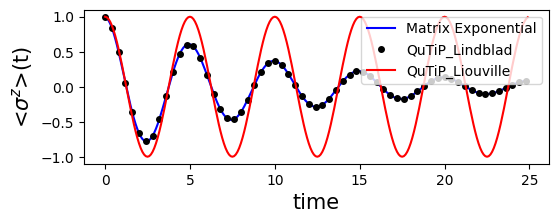

In [ ]:
#==============plot
plt.figure(figsize=(6,2))
plt.plot(time_arr, result_matrix_exp.expect,'b-', label = "Matrix Exponential")
plt.plot(time_arr, expec_vals_qutip_Lindblad[0],'ko',markersize=4,markevery=4, label = "QuTiP_Lindblad")
plt.plot(time_arr, expec_vals_qutip_Liouv[0],'r-', label = "QuTiP_Liouville")
plt.xlabel('time',fontsize=15)
plt.ylabel('<$\sigma^z$>(t)',fontsize=15)
plt.legend(loc = 'upper right')
plt.show()

## Quantum Simulation of the Spin-1/2 system: Amplitude-channel damping

In [ ]:
##================Quantum Simulation: Amplitude damping channel
# System Hamiltonian
Hsys = 0.0 * pa.I

# The collapse operator and damping rate
gamma = 1.52e9*1E-12 # the spontaneous emission rate, ps^-1
c_ops = np.sqrt(gamma)*pa.sigmap

# Initial density matrix
rho0_sdam = np.array([[1/4,1/4],[1/4,3/4]],dtype=np.complex128)

time_sdam = np.arange(0, 1000, 1) #time array, from t=0 to t=1000 ps

#=============instantiation
spin1_sdam = QubitDynamicsOS(rep='Density', Nsys=2, Hsys=Hsys, rho0=rho0_sdam, c_ops = [c_ops])
#set qubit state to measurement
spin1_sdam.set_count_str(['000','011'])
#set the dilation method, which can be 'Sz-Nagy' or 'SVD' or 'SVD-Walsh'
spin1_sdam.set_dilation_method('SVD')

#============quantum simulation
res_quantum = spin1_sdam.qc_simulation_vecdens(time_sdam)
Pop_qc = res_quantum['data']

#compare to classical
res_sdam_classical = spin1_sdam.propagate_matrix_exp(time_sdam, observable=pa.Z, Is_store_state = True)

Pop_Mexp = np.zeros_like(Pop_qc)
for i in range(len(time_sdam)):
    Pop_Mexp[i,0] = res_sdam_classical.density_matrix[i][0,0].real
    Pop_Mexp[i,1] = res_sdam_classical.density_matrix[i][1,1].real

Quantum simulation step 0
Quantum simulation step 100
Quantum simulation step 200
Quantum simulation step 300
Quantum simulation step 400
Quantum simulation step 500
Quantum simulation step 600
Quantum simulation step 700
Quantum simulation step 800
Quantum simulation step 900


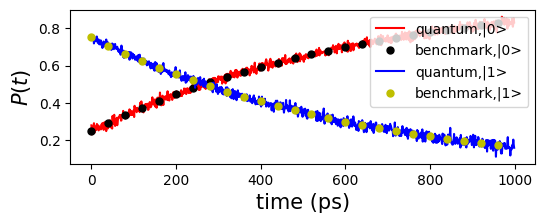

In [ ]:
#============plot
plt.figure(figsize=(6,2))
plt.plot(time_sdam,Pop_qc[:,0],'r-',label="quantum,|0>")
plt.plot(time_sdam,Pop_Mexp[:,0],'ko',markersize=5,markevery=40,label="benchmark,|0>")
plt.plot(time_sdam,Pop_qc[:,1],'b-',label="quantum,|1>")
plt.plot(time_sdam,Pop_Mexp[:,1],'yo',markersize=5,markevery=40,label="benchmark,|1>")
plt.xlabel('time (ps)',fontsize=15)
plt.ylabel('$P(t)$',fontsize=15)
plt.legend(loc = 'upper right')

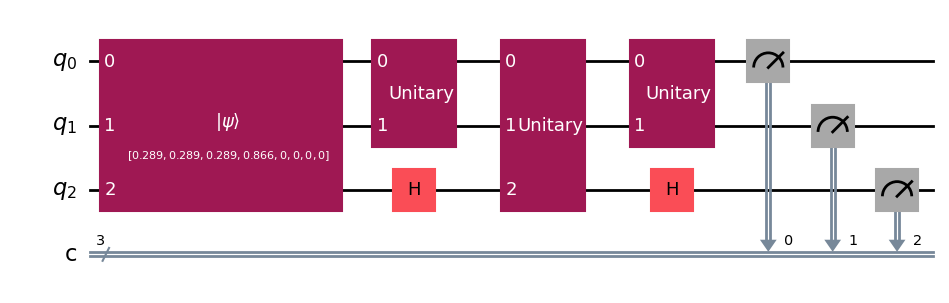

In [23]:
#visualize the quantum circuit
res_quantum['circuits'][200].draw('mpl')

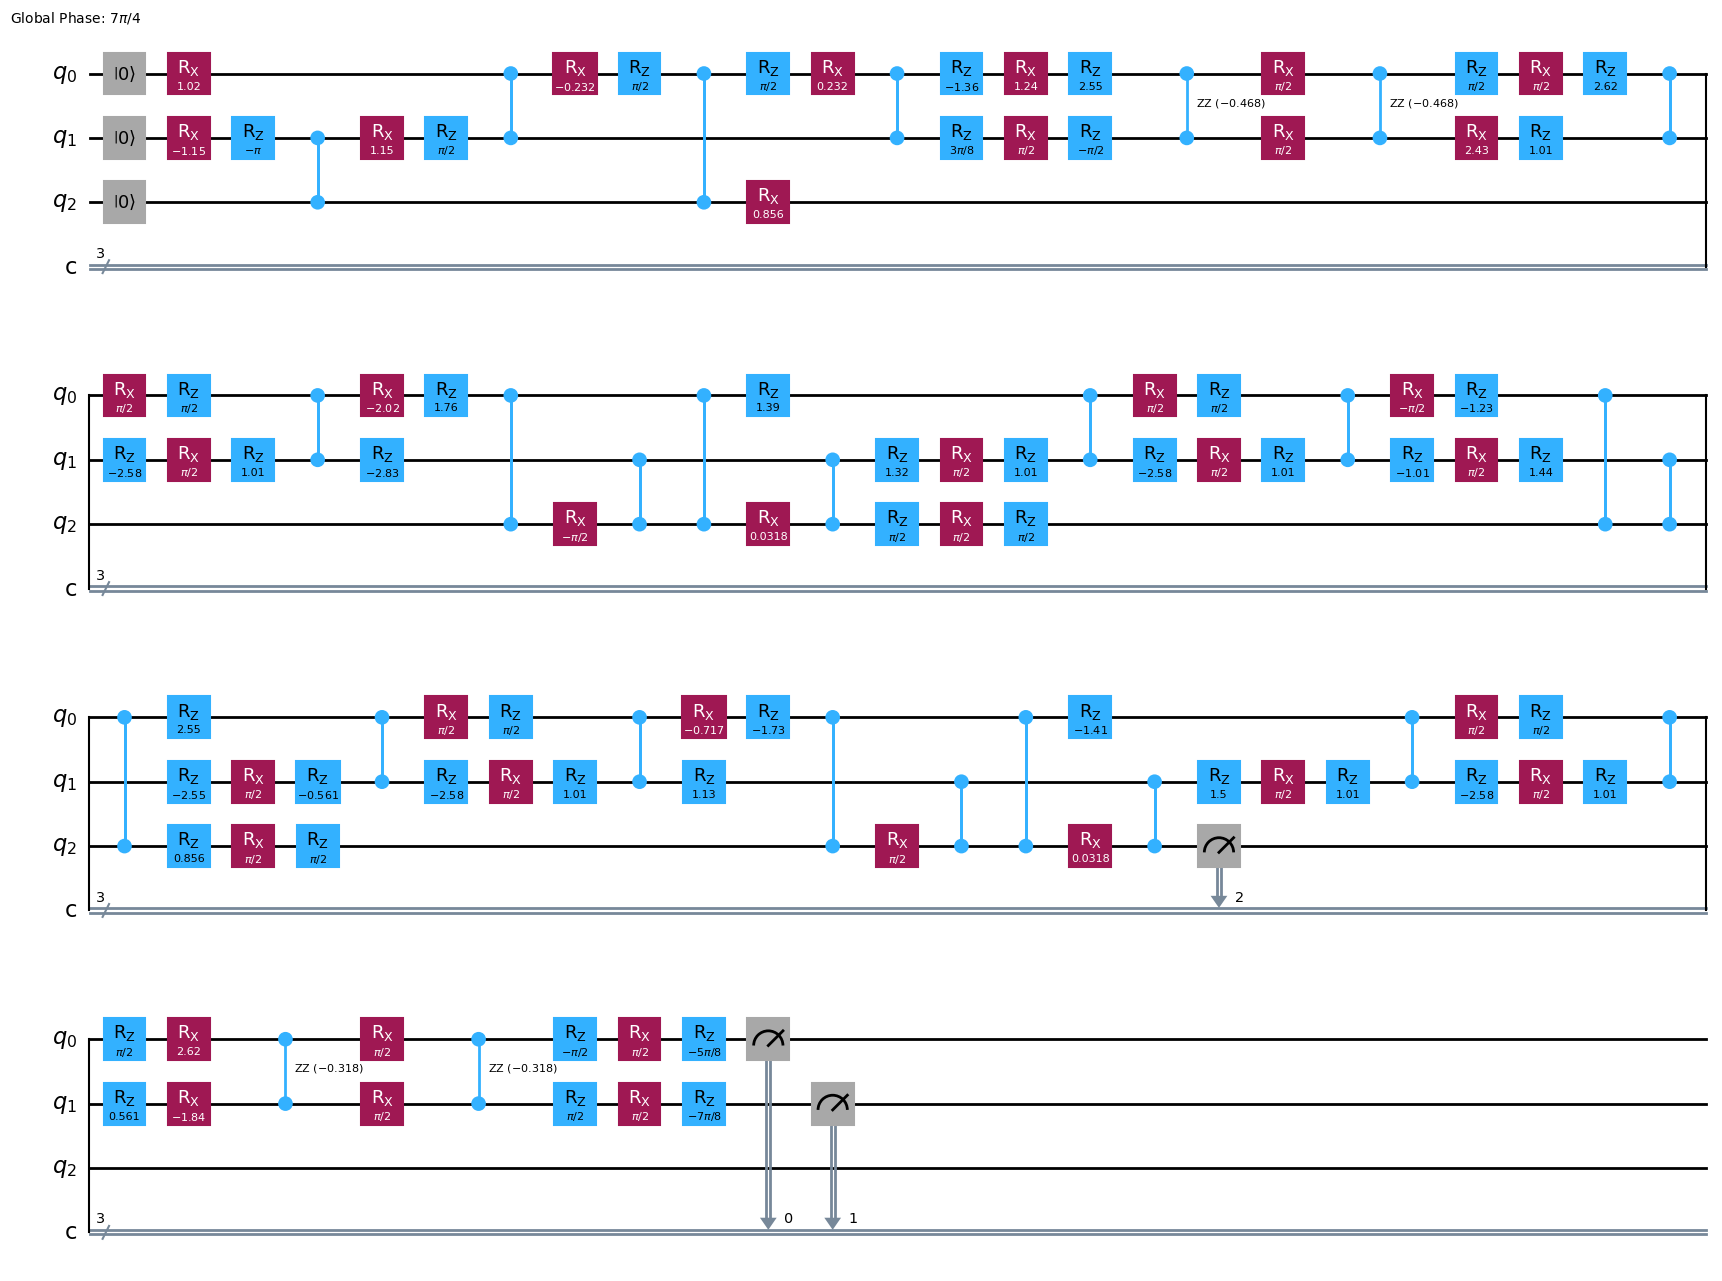

In [22]:
#visualize the complexity quantum circuit by transpiling it into a specific basis gate set.
from qiskit import transpile

basis_gates = ['cz', 'id', 'rx', 'rz', 'rzz', 'sx', 'x']
compiled_circuit = transpile(res_quantum['circuits'][200], basis_gates=basis_gates, optimization_level=1)
compiled_circuit.draw('mpl')

#The spin-chain

##set the Hamiltonian and initial state

In [ ]:
#============set the Hamiltonian and initial state
#the system Hamiltonian parameter
nsite = 3 #this states how many spins in the simulation
Nsys_sc = 2**nsite #this is the dimension of the Hilbert space
Omegai_list = [0.65, 1.0, 1.0]
Jix_list = [0.75, 1.0]
Jiy_list = [0.75, 1.0]
Jiz_list = [0.0, 0.0]

#Hamiltonian in pauli string basis
H_pauli_str = {'ZII':Omegai_list[0], 'IZI':Omegai_list[1], 'IIZ':Omegai_list[2], \
               'XXI':-0.5*Jix_list[0], 'IXX':-0.5*Jix_list[1], \
               'YYI':-0.5*Jiy_list[0], 'IYY':-0.5*Jiy_list[1], \
               'ZZI':-0.5*Jiz_list[0], 'IZZ':-0.5*Jiz_list[1]   }

#system hamiltonian
Hsys = tb.pauli_to_ham(H_pauli_str, 3)


#set up the initial state at [up,down,down...]
init_state = pa.spin_up
for i in range(nsite-1):
  init_state = np.kron(init_state,pa.spin_down)

#set up the initial density matrix according to initial state
rho0_sc = np.zeros((Nsys_sc,Nsys_sc),dtype=np.complex128)
rho0_sc += np.outer(init_state,init_state.conj())

#time array for simulation
time_arr = np.linspace(0, (250 - 1) * 0.1, 250)

#============set the collapse operator
L_sc = []
#The lindblad damping rate
Gamma1 = [0.016]*nsite
Gamma2 = [0.0523]*nsite

for isite in range(nsite):
  #Lindbladian for type 1
  res = 1.0
  for j in range(nsite):
    if(j==isite):
      res = np.kron(res,pa.sigmam)*np.sqrt(Gamma1[isite])
    else:
      res = np.kron(res,pa.I)
  L_sc.append(res)

  #Lindbladian for type 2
  res = 1.0
  for j in range(nsite):
    if(j==isite):
      res = np.kron(res,pa.sigmap@pa.sigmam)*np.sqrt(Gamma2[isite])
    else:
      res = np.kron(res,pa.I)
  L_sc.append(res)

##classical simulation

In [ ]:
##===========Classical Simulation
#=============instantiation
spin_chain_puresys =  DynamicsOS(Nsys=Nsys_sc, Hsys=Hsys, rho0=rho0_sc)
spin_chain_opensys =  DynamicsOS(Nsys=Nsys_sc, Hsys=Hsys, rho0=rho0_sc, c_ops = L_sc)

#=============propagation
# QuTiP Propagation for the pure system Liouville equation (for comparison)
result_qutip_Liouv = spin_chain_puresys.propagate_qt(time_arr=time_arr, observable=rho0_sc)

#matrix exponential propagation
result_matrix_exp = spin_chain_opensys.propagate_matrix_exp(time_arr=time_arr, observable=rho0_sc)

# QuTiP Propagation for the Lindblad equation
result_qutip_Lindblad = spin_chain_opensys.propagate_qt(time_arr=time_arr, observable=rho0_sc)

As_matrix_exp = np.sqrt(result_matrix_exp.expect[:])
As_qutip = np.sqrt(result_qutip_Lindblad[0][:])
As_qutip_liouv = np.sqrt(result_qutip_Liouv[0][:])

/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


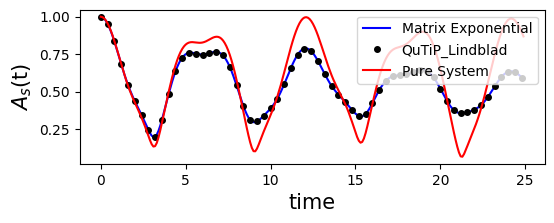

In [ ]:
#==============plot
plt.figure(figsize=(6,2))
plt.plot(time_arr,As_matrix_exp,'b-', label="Matrix Exponential")
plt.plot(time_arr,As_qutip,'ko',markersize=4,markevery=4,label="QuTiP_Lindblad")
plt.plot(time_arr,As_qutip_liouv,'r-',label="Pure System")
plt.xlabel('time',fontsize=15)
plt.ylabel('$A_s$(t)',fontsize=15)
plt.legend(loc = 'upper right')

##Quantum Simulation


In [ ]:
##===========Quantum Simulation
qspin_chain = QubitDynamicsOS(rep='Density',Nsys=Nsys_sc, Hsys=Hsys, rho0=rho0_sc, c_ops = L_sc)
qspin_chain.set_count_str(['0011011'])

res_qc_1k = qspin_chain.qc_simulation_vecdens(time_arr,shots=1000)
res_qc_1w = qspin_chain.qc_simulation_vecdens(time_arr,shots=10000)

As_qc_1k = np.sqrt(res_qc_1k['data'])
As_qc_1w = np.sqrt(res_qc_1w['data'])

Quantum simulation step 0
At time 32 with shots = 1000 no counts for 0011011
Quantum simulation step 100
Quantum simulation step 200
Quantum simulation step 0
Quantum simulation step 100
Quantum simulation step 200


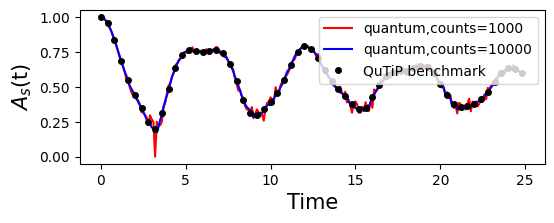

In [ ]:
#==============plot
plt.figure(figsize=(6,2))
plt.plot(time_arr,As_qc_1k[:],'r-',label=f"quantum,counts={1000}")
plt.plot(time_arr,As_qc_1w[:],'b-',label=f"quantum,counts={10000}")
plt.plot(time_arr,As_qutip,'ko',markersize=4,markevery=4,label="QuTiP benchmark")
plt.xlabel('Time',fontsize=15)
plt.ylabel('$A_s$(t)',fontsize=15)
plt.legend(loc = 'upper right')

#The Double-Well

##set up the double well

In [ ]:
from qflux.open_systems.numerical_methods import DVR_grid

#=============set up the double well in the grid point representation
def pot_doublewell(x, f=0.0367493, a0=0.0, a1=0.429, a2=-1.126, a3=-0.143, a4=0.563):
    # A-T pair double-well potential in Hartrees (x is in Bohr)
    xi = x/1.9592
    return f*(a0 + a1*xi + a2*xi**2 + a3*xi**3 + a4*xi**4)

mass0 = 1836.15
beta = pa.au2joule/(pa.bolz*300) #1/(kT) in a.u. units
omega = 0.00436 #the frequency associate with the right well
kappa = 1/(10/pa.au2fs)
nth = 1/(np.exp(beta*omega)-1)

dw_grid = DVR_grid(xmin = -4.0, xmax = 4.0, Ngrid = 1024, mass = mass0)

dw_grid.set_potential(pot_doublewell)

###the eigen state of the double-well

In [ ]:
#=============The eigen_state
Neig = 50
eneg_DW,psi_DW = dw_grid.get_eig_state(Neig)

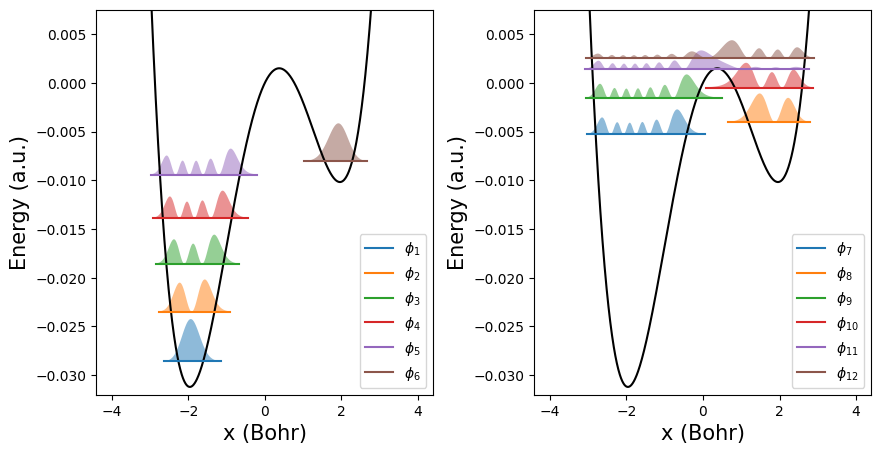

In [ ]:
#========plot the eigenenergy and the distribution
xgrid = dw_grid.xgrid
pot_arr = dw_grid.potential

#distribution
dis = []
for i in range(Neig):
  dis.append(abs(psi_DW[:,i])**2)

x_arr1 = {}
eig_arr1 = {}
dis_plot = {}

for i in range(Neig):
  x_arr1[i]=[]
  eig_arr1[i] = []
  dis_plot[i] = []
  for j in range(len(xgrid)):
    if(abs(dis[i][j])>1E-2):
      x_arr1[i].append(xgrid[j])
      eig_arr1[i].append(eneg_DW[i])
      dis_plot[i].append(dis[i][j])
  dis_plot[i] = np.array(dis_plot[i])

#plot
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(xgrid,pot_arr,'k')

const = 0.0025
for i in range(6):
  plt.plot(x_arr1[i],eig_arr1[i],label=rf'$\phi_{{{i+1}}}$')
  #plt.plot(x_arr1[i],(dis_plot[i]*const+eneg_DW[i]))
  plt.fill_between(x_arr1[i], (dis_plot[i]*const+eneg_DW[i]), eig_arr1[i],alpha=0.5)
plt.ylim((-0.032, 0.0075))
plt.xlabel('x (Bohr)',fontsize=15)
plt.ylabel('Energy (a.u.)',fontsize=15)
plt.legend(loc = 'lower right')

plt.subplot(122)
plt.plot(xgrid,pot_arr,'k')
for i in range(6,12):
  #plt.plot(x_arr1[i],(dis_plot[i]*const+eneg_DW[i]))
  plt.plot(x_arr1[i],eig_arr1[i],label=rf'$\phi_{{{i+1}}}$')
  plt.fill_between(x_arr1[i], (dis_plot[i]*const+eneg_DW[i]), eig_arr1[i],alpha=0.5)

plt.subplots_adjust(wspace=0.3)
plt.ylim((-0.032, 0.0075))
plt.xlabel('x (Bohr)',fontsize=15)
plt.ylabel('Energy (a.u.)',fontsize=15)
plt.legend(loc = 'lower right')
plt.show()
#=================

###Express the double well in terms of eigenstate basis

In [ ]:
#==================Express the operators in terms of eigenstate basis===========
psik_DW = np.zeros((dw_grid.Ngrid,Neig),dtype=np.complex128)
for i in range(Neig):
    psik_DW[:,i] = dw_grid.x2k_wave(psi_DW[:,i])

#hamiltonian
H_dw = np.diag(eneg_DW)

#The operator in the eigenstate
xmat_eig = tb.trans_basis_diag(dw_grid.xgrid, Neig, psi_DW)*dw_grid.dx
pmat_eig = tb.trans_basis_diag(dw_grid.kgrid, Neig, psik_DW)*dw_grid.dk

#creation/annihilation operator
amat_eig = xmat_eig.copy()*np.sqrt(mass0*omega/2)+1j*pmat_eig.copy()/np.sqrt(mass0*omega*2)
adegmat_eig = xmat_eig.copy()*np.sqrt(mass0*omega/2)-1j*pmat_eig.copy()/np.sqrt(mass0*omega*2)

#define the population on the left/right well and transform to eigen state basis
x_barrier = 0.37321768
P_R = np.heaviside(xgrid-x_barrier,1)
P_L = 1 - np.heaviside(xgrid-x_barrier,1)

P_R_eig = tb.trans_basis_diag(P_R, Neig, psi_DW)*dw_grid.dx
P_L_eig = tb.trans_basis_diag(P_L, Neig, psi_DW)*dw_grid.dx

#initial density matrix
ini_occu = np.zeros(Neig,dtype=np.complex128)
ini_occu[5] = 1.0
rho0 = np.outer(ini_occu,ini_occu.conj())

##Classical simulation

In [ ]:
##==================classical simulation============================
#propogate using QuTiP
gamma1 = np.sqrt(kappa*(nth+1))
gamma2 = np.sqrt(kappa*(nth))

time_qtp = np.linspace(0,1000/pa.au2fs,20000)

#Double_Well with different eigenstates truncation
dw_eig = {}
result_qtp = {}
for N_eig_use in [20,30,40]:
    c_ops = [gamma1*amat_eig[:N_eig_use,:N_eig_use], gamma2*adegmat_eig[:N_eig_use,:N_eig_use]]
    dw_eig[N_eig_use] = DynamicsOS(Nsys = N_eig_use, Hsys = H_dw[:N_eig_use,:N_eig_use], \
                                      rho0 = rho0[:N_eig_use,:N_eig_use], c_ops = c_ops)

    obs = [P_R_eig[:N_eig_use,:N_eig_use], P_L_eig[:N_eig_use,:N_eig_use]]
    result_qtp[N_eig_use] = dw_eig[N_eig_use].propagate_qt(time_qtp, obs, progress_bar=True)

/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:479: FutureWarning: "progress_bar" is now included in options:
 Use `options={"progress_bar": False / True / "tqdm" / "enhanced"}`
  warnings.warn(


10.0%. Run time:   0.51s. Est. time left: 00:00:00:04
20.0%. Run time:   0.94s. Est. time left: 00:00:00:03
30.0%. Run time:   1.38s. Est. time left: 00:00:00:03
40.0%. Run time:   1.78s. Est. time left: 00:00:00:02
50.0%. Run time:   2.17s. Est. time left: 00:00:00:02
60.0%. Run time:   2.58s. Est. time left: 00:00:00:01
70.0%. Run time:   2.97s. Est. time left: 00:00:00:01
80.0%. Run time:   3.39s. Est. time left: 00:00:00:00
90.0%. Run time:   5.98s. Est. time left: 00:00:00:00
100.0%. Run time:   8.12s. Est. time left: 00:00:00:00
Total run time:   8.13s
10.0%. Run time:   2.52s. Est. time left: 00:00:00:22
20.0%. Run time:   4.27s. Est. time left: 00:00:00:17
30.0%. Run time:   6.06s. Est. time left: 00:00:00:14
40.0%. Run time:   7.63s. Est. time left: 00:00:00:11
50.0%. Run time:  11.80s. Est. time left: 00:00:00:11
60.0%. Run time:  14.30s. Est. time left: 00:00:00:09
70.0%. Run time:  15.58s. Est. time left: 00:00:00:06
80.0%. Run time:  16.87s. Est. time left: 00:00:00:04
90.

In [ ]:
#this section will approximate take 10 minutes
#propagate using matrix exponential propagation
N_eig_use=30
c_ops = [gamma1*amat_eig[:N_eig_use,:N_eig_use], gamma2*adegmat_eig[:N_eig_use,:N_eig_use]]
observable = P_R_eig[:N_eig_use,:N_eig_use]

time_short = np.linspace(0,1000/pa.au2fs,30) #compare to QuTiP time scale
result_s = dw_eig[N_eig_use].propagate_matrix_exp(time_short, observable, Is_show_step=True)

time_long = np.linspace(0,20000/pa.au2fs,60) #long time propagation
result_dw_l = dw_eig[N_eig_use].propagate_matrix_exp(time_long, observable, \
                                Is_store_state = True, Is_show_step=True, Is_Gt=True)

step 0 time 0.0
step 1 time 1425.5646405431376
step 2 time 2851.129281086275
step 3 time 4276.693921629412
step 4 time 5702.25856217255
step 5 time 7127.823202715688
step 6 time 8553.387843258824
step 7 time 9978.952483801962
step 8 time 11404.5171243451
step 9 time 12830.081764888238
step 10 time 14255.646405431376
step 11 time 15681.211045974513
step 12 time 17106.77568651765
step 13 time 18532.34032706079
step 14 time 19957.904967603925
step 15 time 21383.469608147065
step 16 time 22809.0342486902
step 17 time 24234.598889233337
step 18 time 25660.163529776477
step 19 time 27085.728170319613
step 20 time 28511.292810862753
step 21 time 29936.85745140589
step 22 time 31362.422091949025
step 23 time 32787.986732492165
step 24 time 34213.5513730353
step 25 time 35639.11601357844
step 26 time 37064.68065412158
step 27 time 38490.24529466472
step 28 time 39915.80993520785
step 29 time 41341.37457575099
step 0 time 0.0
step 1 time 14014.02527991559
step 2 time 28028.05055983118
step 3 tim

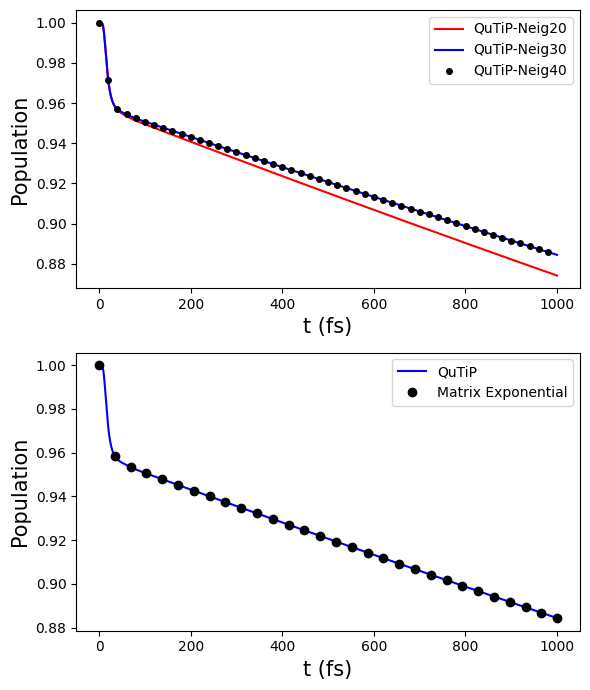

In [ ]:
#======================plot the classical results======================
fig, axs = plt.subplots(2, 1, figsize=(6, 7))
axs[0].plot(time_qtp*pa.au2fs,result_qtp[20][0],'r-',label = 'QuTiP-Neig20')
axs[0].plot(time_qtp*pa.au2fs,result_qtp[30][0],'b-',label = 'QuTiP-Neig30')
axs[0].plot(time_qtp*pa.au2fs,result_qtp[40][0],'ko',markersize=4,markevery=400,label = 'QuTiP-Neig40')
axs[0].set_xlabel('t (fs)',fontsize=15)
axs[0].set_ylabel('Population',fontsize=15)
axs[0].legend(loc = 'upper right')

#plt.figure(figsize=(6,3))
axs[1].plot(time_qtp*pa.au2fs,result_qtp[30][0],'b-',label = 'QuTiP')
axs[1].plot(time_short*pa.au2fs,result_s.expect[:],'ko',label = 'Matrix Exponential')
axs[1].set_xlabel('t (fs)',fontsize=15)
axs[1].set_ylabel('Population',fontsize=15)
axs[1].legend(loc = 'upper right')

plt.tight_layout()

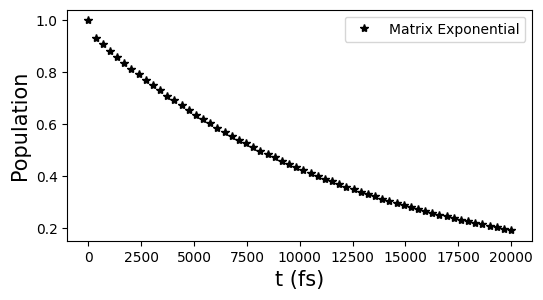

In [ ]:
plt.figure(figsize=(6,3))
plt.plot(time_long*pa.au2fs,result_dw_l.expect,'k*',label = 'Matrix Exponential')
plt.xlabel('t (fs)',fontsize=15)
plt.ylabel('Population',fontsize=15)
plt.legend(loc = 'upper right')

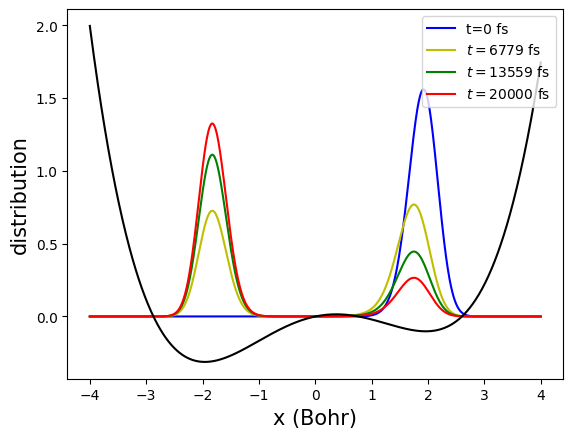

In [ ]:
#extract the distribution
dis_list = []
for nn in [0,20,40,59]:
  rho = result_dw_l.density_matrix[nn]
  rho_grid = np.matmul(np.matmul(psi_DW[:,:N_eig_use],rho),psi_DW[:,:N_eig_use].conj().T)
  dis_list.append(rho_grid.diagonal().real)

#plot
plt.plot(xgrid,dis_list[0],'b',label='t=0 fs')
plt.plot(xgrid,dis_list[1],'y',label=rf'$t={{{int(time_long[20]*pa.au2fs)}}}$ fs')
plt.plot(xgrid,dis_list[2],'g',label=rf'$t={{{int(time_long[40]*pa.au2fs)}}}$ fs')
plt.plot(xgrid,dis_list[3],'r',label=rf'$t={{{int(time_long[59]*pa.au2fs)}}}$ fs')
plt.plot(xgrid,pot_arr*10,'k')
plt.xlabel('x (Bohr)',fontsize=15)
plt.ylabel('distribution',fontsize=15)
plt.legend(loc = 'upper right')
plt.show()

##Quantum Simulation

In [ ]:
from qflux.open_systems.quantum_simulation import expand

##===============Quantum Simulation ====================================
dim_dw = 32

# initial state of the double-well in the dilated space
ini_occu = np.zeros(dim_dw,dtype=np.complex128)
ini_occu[5] = 1.0
rho0 = np.outer(ini_occu,ini_occu.conj())

#hamiltonian
Hsys = H_dw[:dim_dw,:dim_dw]

#collapse operator and observable
c_ops = [gamma1*amat_eig[:dim_dw,:dim_dw], gamma2*adegmat_eig[:dim_dw,:dim_dw]]
observable = P_R_eig[:dim_dw,:dim_dw]

#extract the propagator from result of classical simulation,
#and expand to match the dimension of qubit space
#For saving calculation, only choose some time points
ilarge = 5
nsteps = int(len(time_long)/ilarge)
time_qdw = np.zeros(nsteps)
Gprop_dw = []

for i0 in range(nsteps):
    i = i0*ilarge
    org_dim = result_dw_l.density_matrix[i].shape[0]
    Gprop_dw.append(expand(result_dw_l.Gprop[i],org_dim,dim_dw))

    time_qdw[i0] = time_long[i]

#double well instance
dw_quantum = QubitDynamicsOS(rep='Kraus', Nsys=dim_dw, Hsys=Hsys, rho0=rho0, c_ops = c_ops)
dw_quantum.set_observable(observable)

#running the quantum simulation
res_dw_qc = dw_quantum.qc_simulation_kraus(time_qdw, shots=2000,  Gprop = Gprop_dw, tolk = 1E-2, tolo = 5E-3)
P_dw_qc = res_dw_qc['data']

Generating the Kraus operators
At step 0 of 12
At step 1 of 12
At step 2 of 12
At step 3 of 12
At step 4 of 12
At step 5 of 12
At step 6 of 12
At step 7 of 12
At step 8 of 12
At step 9 of 12
At step 10 of 12
At step 11 of 12
Kraus operator generation complete
Number of initial states in the density matrix: 1
Probabilities: [1.0]
Starting quantum simulation
Simulation step 0 of 12
Number of Kraus operators: 1
Simulation step 1 of 12
Number of Kraus operators: 78
Simulation step 2 of 12
Number of Kraus operators: 76
Simulation step 3 of 12
Number of Kraus operators: 77
Simulation step 4 of 12
Number of Kraus operators: 76
Simulation step 5 of 12
Number of Kraus operators: 77
Simulation step 6 of 12
Number of Kraus operators: 77
Simulation step 7 of 12
Number of Kraus operators: 75
Simulation step 8 of 12
Number of Kraus operators: 75
Simulation step 9 of 12
Number of Kraus operators: 73
Simulation step 10 of 12
Number of Kraus operators: 76
Simulation step 11 of 12
Number of Kraus operat

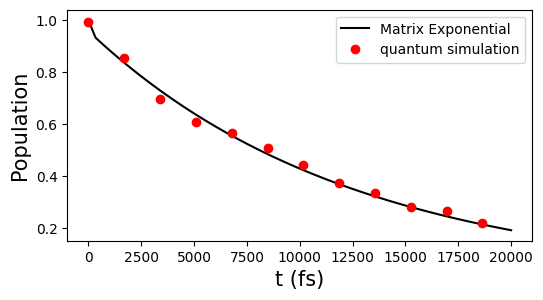

In [ ]:
#=================plot=========================
plt.figure(figsize=(6,3))
plt.plot(time_long*pa.au2fs,result_dw_l.expect,'k-',label = 'Matrix Exponential')
plt.plot(time_qdw*pa.au2fs,P_dw_qc,'ro',label = 'quantum simulation')
plt.xlabel('t (fs)',fontsize=15)
plt.ylabel('Population',fontsize=15)
plt.legend(loc = 'upper right')
plt.show()